# `Занятие 5: Сегментация`

### `Практикум на ЭВМ для 317 группы, ВМК МГУ, кафедра ММП`

### `Афанасьев Глеб, Варламова Арина, кафедра ММП ВМК МГУ`

## `Задача сегментации изображений`

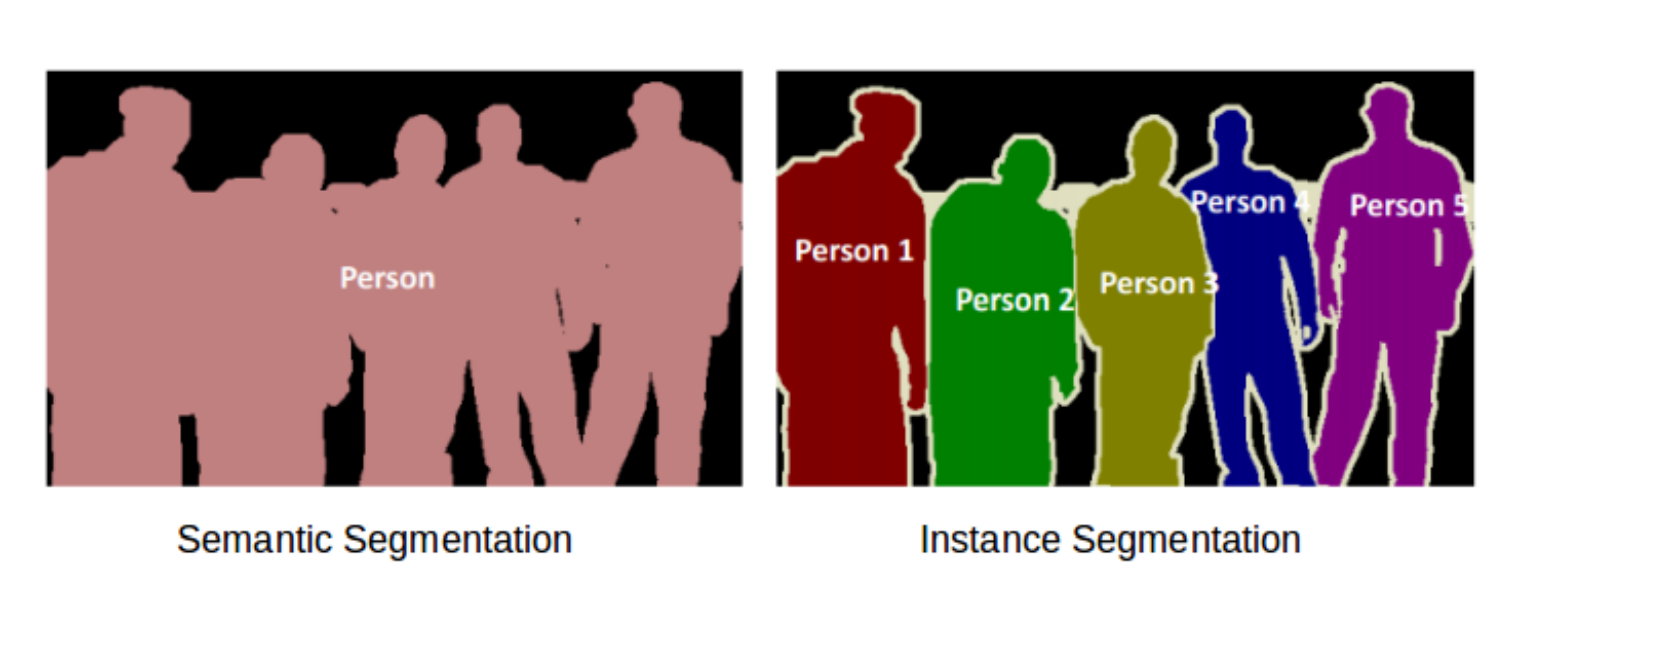

### `Классическая схема сегментационных нейронных сетей — сверточный кодировщик-декодировщик`

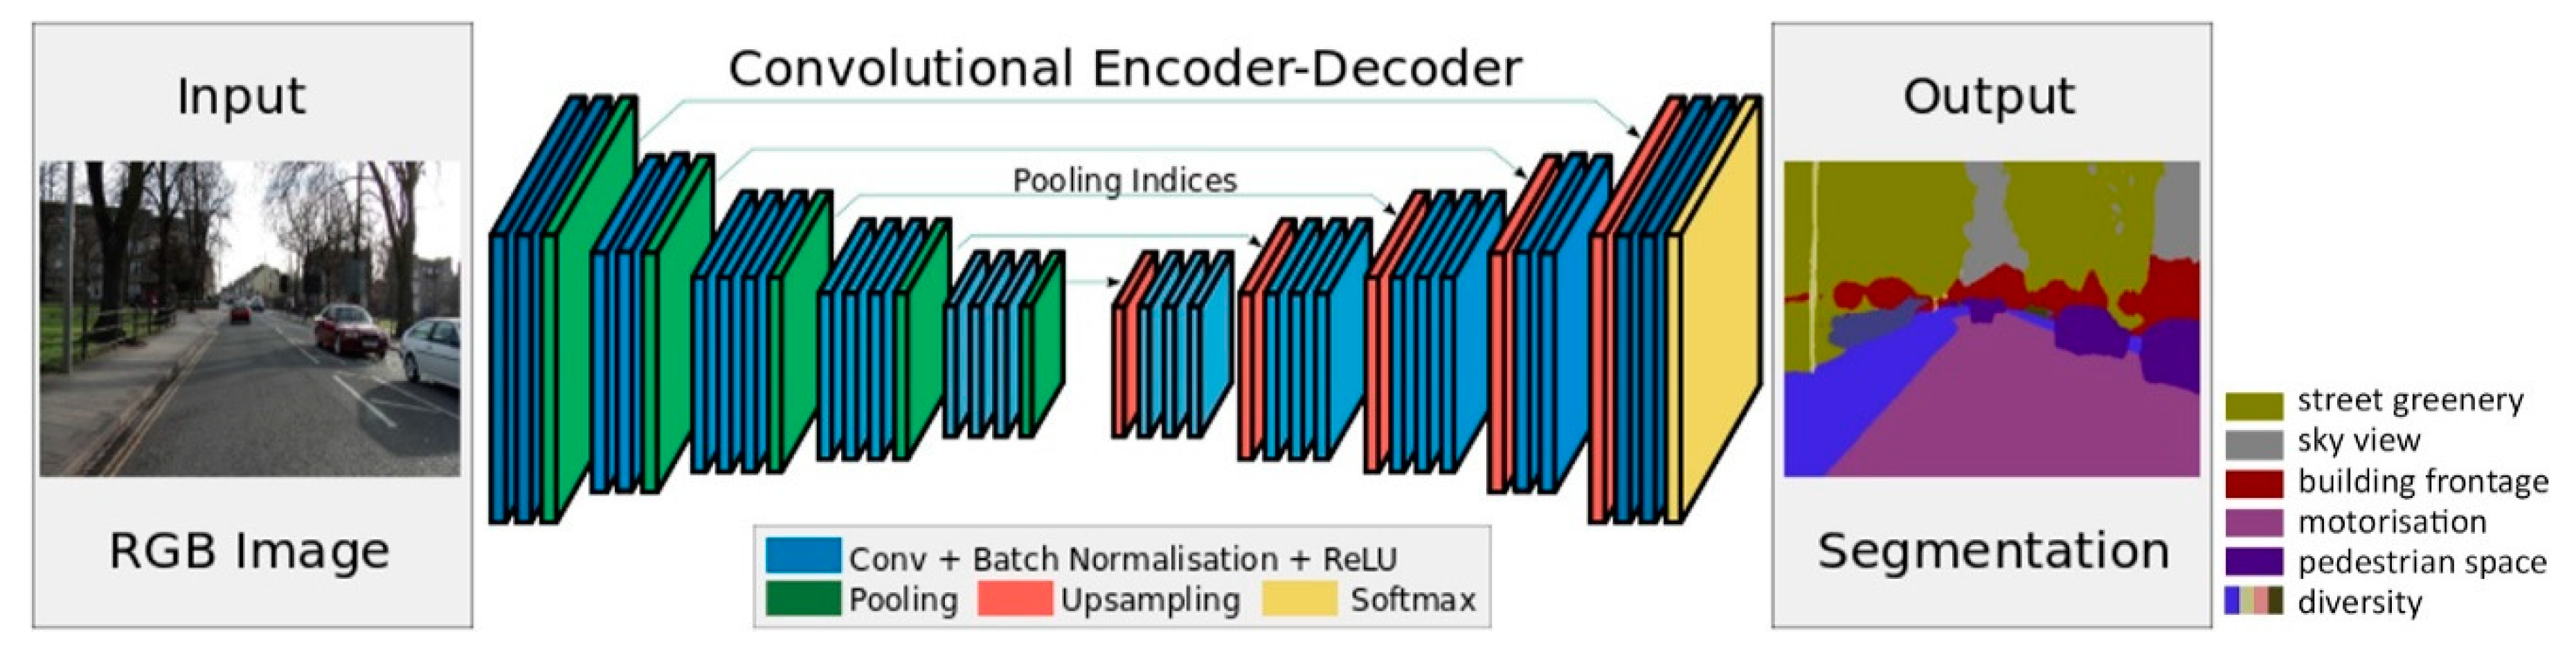

1) Проблема: ответ должен быть близок по размеру ко входу

2) Проблема: чем глубже тем лучше понимаем что изображено, но забываем контекст

3) Receptive field на последних слоях должен быть достаточно большим

## `Операции увеличения размерности:`

### `1. Upsampling`

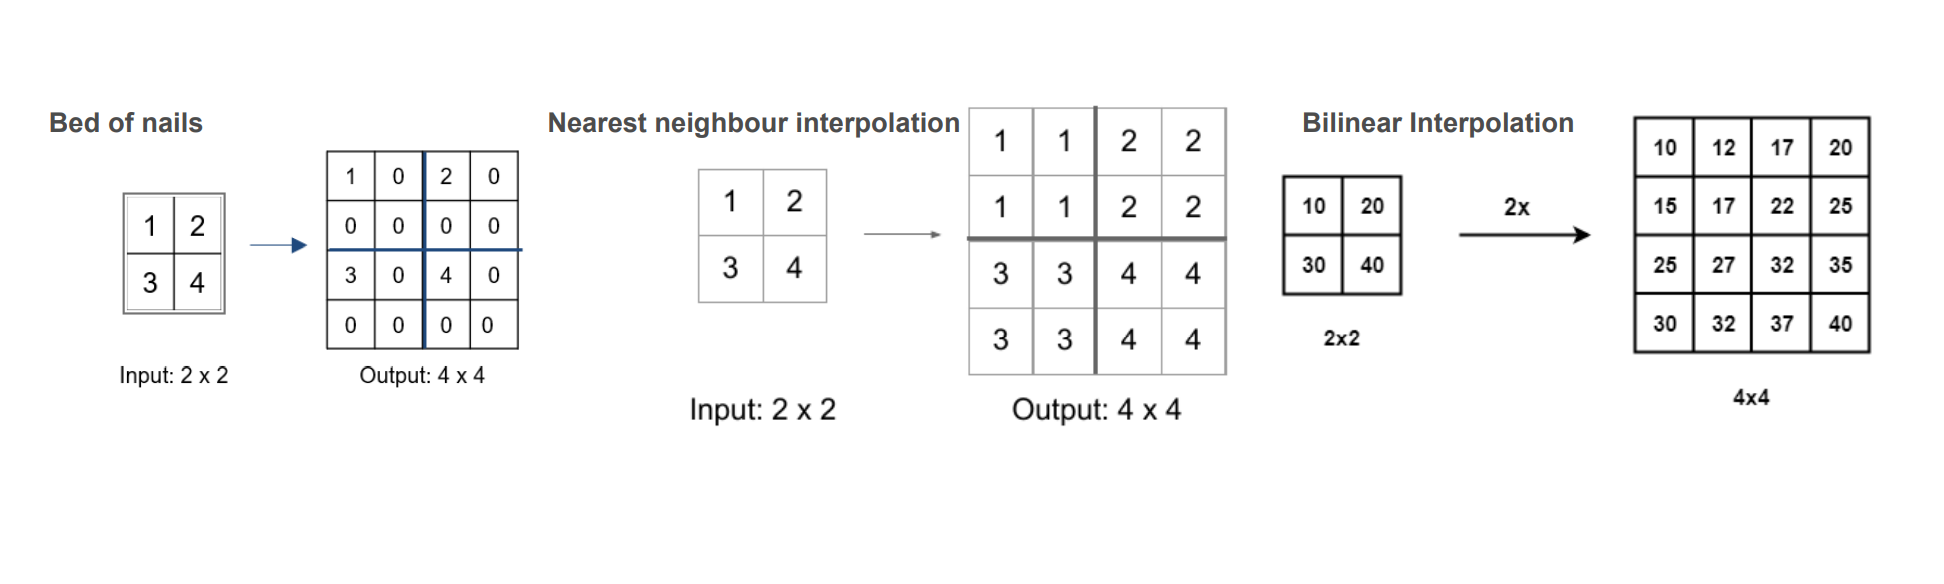

In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
import torch

In [3]:
?torch.nn.Upsample

In [4]:
ex = torch.randint(0, 100, (2,2)).view(1, 1, 2, 2).float()
ex

tensor([[[[18., 77.],
          [56., 52.]]]])

In [5]:
ups = torch.nn.Upsample(scale_factor=(2,3), mode='nearest')
ups(ex)

tensor([[[[18., 18., 18., 77., 77., 77.],
          [18., 18., 18., 77., 77., 77.],
          [56., 56., 56., 52., 52., 52.],
          [56., 56., 56., 52., 52., 52.]]]])

In [6]:
ups = torch.nn.Upsample(scale_factor=2, mode='bilinear')
ups(ex)

tensor([[[[18.0000, 32.7500, 62.2500, 77.0000],
          [27.5000, 38.3125, 59.9375, 70.7500],
          [46.5000, 49.4375, 55.3125, 58.2500],
          [56.0000, 55.0000, 53.0000, 52.0000]]]])

### `2. Транспонированная свертка`

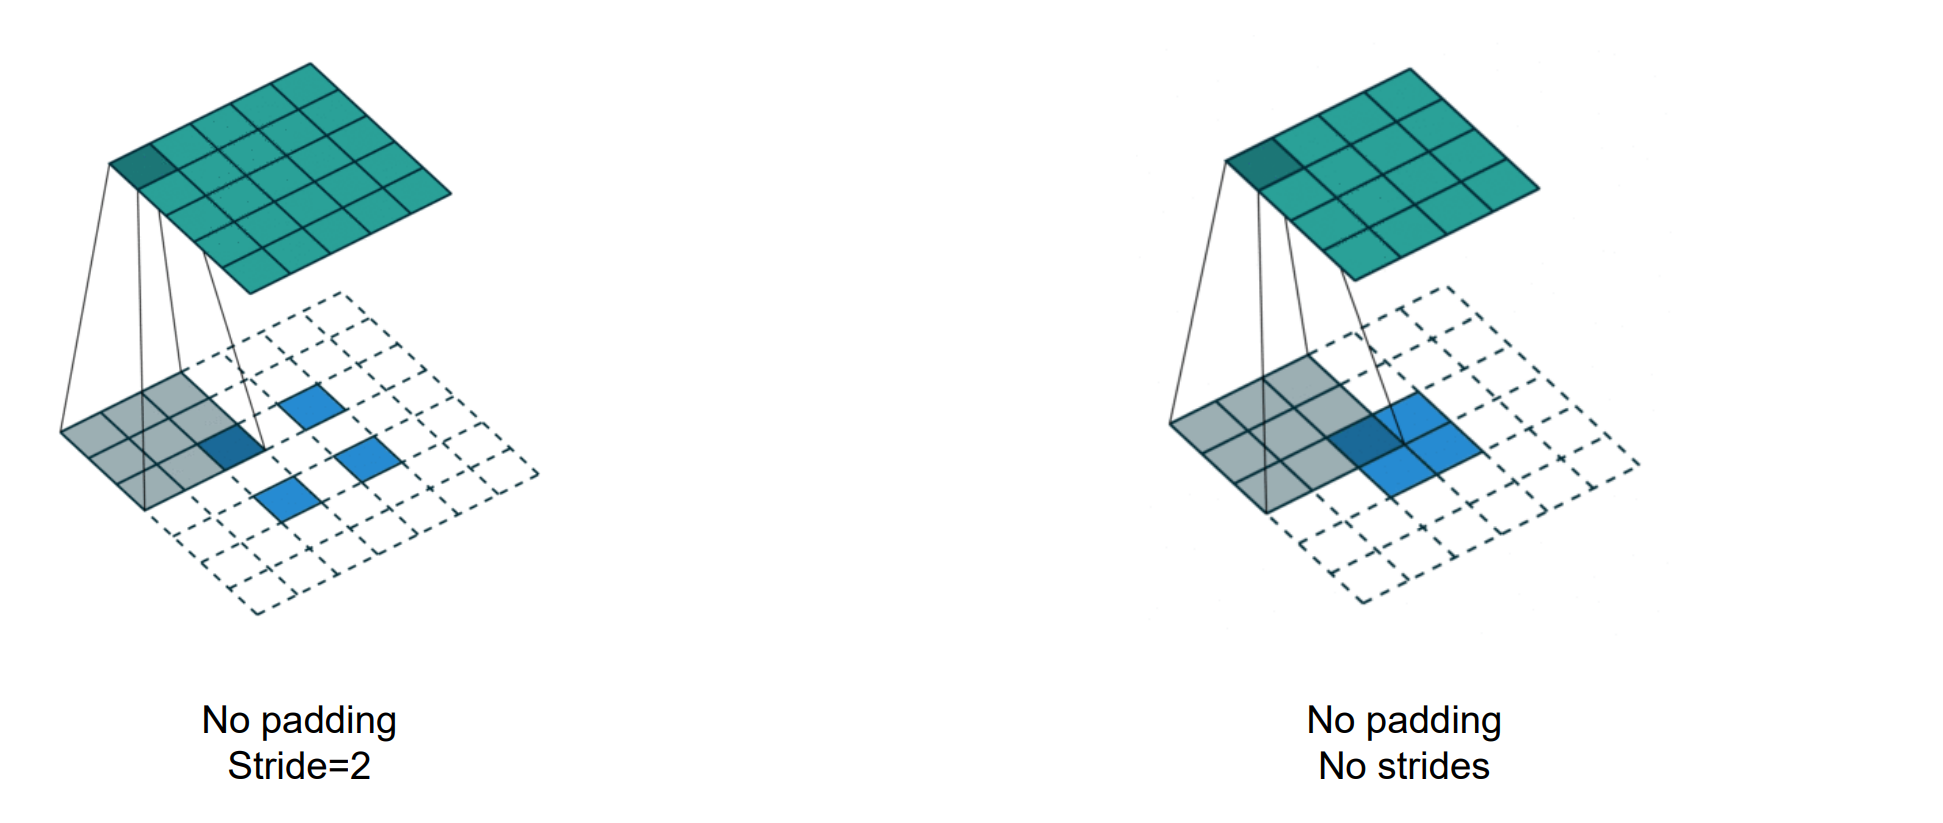

In [7]:
?torch.nn.ConvTranspose2d

```python
torch.nn.ConvTranspose2d(
    in_channels, out_channels, kernel_size, stride=1,
    padding=0, output_padding=0, groups=1, bias=True,
    dilation=1, padding_mode='zeros', device=None,
    dtype=None
)
```

In [8]:
upconv = torch.nn.ConvTranspose2d(1, 1, 3)
ex = torch.randint(0, 100, (2,2)).view(1, 1, 2, 2).float()
ex

tensor([[[[ 4., 90.],
          [82., 92.]]]])

In [9]:
upconv(ex)

tensor([[[[ -0.5460, -14.5204, -21.1901,  -3.4673],
          [-11.9669, -25.1144, -49.2451,  -7.1381],
          [  7.2934, -36.9006, -46.3336, -22.1366],
          [-21.1322, -39.5579, -34.5908, -18.8760]]]],
       grad_fn=<ConvolutionBackward0>)

## `U-Net`

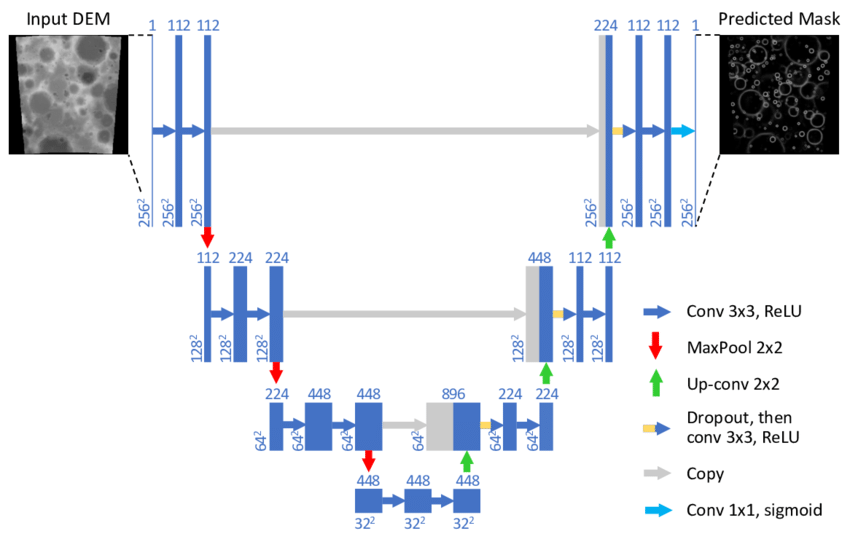

## `LinkNet`

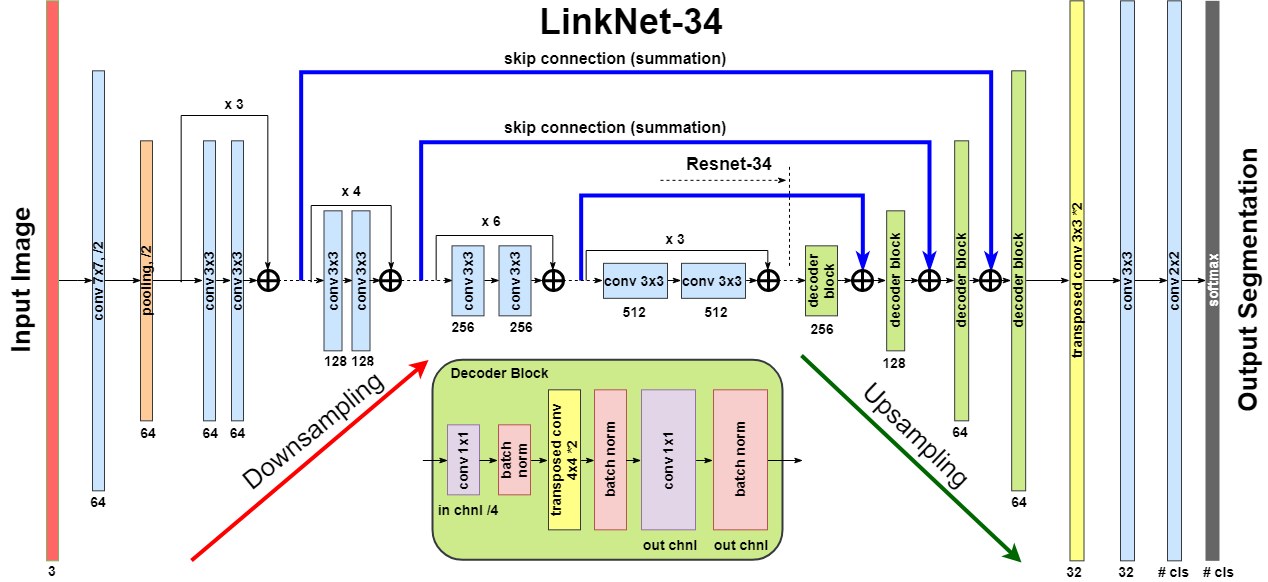

In [10]:
import utils

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Normalize

import tqdm.notebook as tqdm

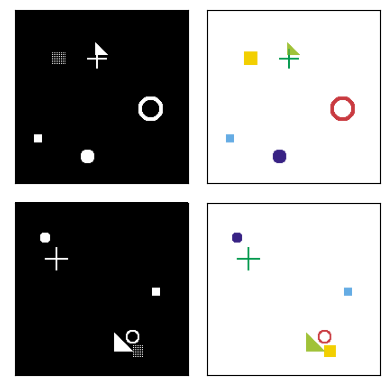

In [11]:
input_images, target_masks = utils.generate_random_data(192, 192, count=2)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]
# Map each channel (i.e. class) to each color
target_masks_rgb = [utils.masks_to_colorimg(x) for x in target_masks]
# Left: Input image (black and white), Right: Target mask (6ch)
utils.plot_side_by_side([input_images_rgb, target_masks_rgb])

In [12]:
input_images, target_masks = utils.generate_random_data(192, 192, count=2)
input_images.shape, target_masks.shape

((2, 192, 192, 3), (2, 6, 192, 192))

In [13]:
input_images.max(), target_masks.max()

(255, 1.0)

## `Датасет`

In [14]:
class ShapeDataset(Dataset):
    def __init__(
        self, n_images=2000, width=224, height=224, transforms=None
    ):
        super().__init__()
        
        self.X, self.y = utils.generate_random_data(
            width=width, height=height, count=n_images
        )
        self.transform = transforms
        
    def __getitem__(self, idx):
        image = self.X[idx]
        image = (image / 255).astype('float32')
        image = torch.from_numpy(image).permute(2, 0, 1)
        
        mask = self.y[idx]
        mask = torch.from_numpy(mask)
        if transforms is not None:
            image =self.transform(image)
        return image, mask
    
    def __len__(self):
        return self.X.shape[0]

In [15]:
transforms = Compose([
    Normalize(
        (0.485, 0.456, 0.406), 
        (0.229, 0.224, 0.225))
])
dataset = ShapeDataset(n_images=10, transforms=transforms)

In [16]:
image, mask = dataset[5]

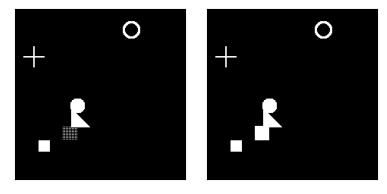

In [17]:
with mpl.rc_context({'image.cmap': 'gray'}):
    utils.plot_side_by_side([[image.numpy()[0]], [np.max(mask.numpy(), axis=0)]])

## `Нейронная сеть`

### `Encoder`

![vggarc.png](https://raw.githubusercontent.com/mmp-practicum-team/mmp_practicum_spring_2022/main/Seminars/Seminar%2005/images/vggarc.png)

**Conv2d:**

![conv2d.png](https://raw.githubusercontent.com/mmp-practicum-team/mmp_practicum_spring_2022/main/Seminars/Seminar%2005/images/conv2d.png)

In [18]:
class VGGBlock(torch.nn.Module):
    def __init__(
        self, in_channels=3, out_channels=64, 
        conv_layers=2, batch_norm=True
    ):
        super().__init__()
        
        layers = []
        for _ in range(conv_layers):
            layers.append(
                torch.nn.Conv2d(
                    in_channels, out_channels, 
                    kernel_size=3, padding=1
                )
            )
            in_channels = out_channels
            if batch_norm:
                layers.append(torch.nn.BatchNorm2d(out_channels))
            layers.append(torch.nn.ReLU())
        layers.append(torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.block = torch.nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.block(x)
        return x

In [19]:
class VGG16(torch.nn.Module):
    def __init__(self, batch_norm=True):
        super().__init__()
        
        block_sequence = [
            VGGBlock(3, 64, 2, batch_norm),
            VGGBlock(64, 128, 2, batch_norm),
            VGGBlock(128, 256, 3, batch_norm),
            VGGBlock(256, 512, 3, batch_norm), 
            VGGBlock(512, 512, 3, batch_norm)
        ]
        self.block_sequence = torch.nn.Sequential(*block_sequence)
    def forward(self, x):
        x = self.block_sequence(x)
        return x

### `Full model`

![encdec1.png](https://raw.githubusercontent.com/mmp-practicum-team/mmp_practicum_spring_2022/main/Seminars/Seminar%2005/images/encdec1.png)

**ConvTransposed2d:**
![transposed.png](https://raw.githubusercontent.com/mmp-practicum-team/mmp_practicum_spring_2022/main/Seminars/Seminar%2005/images/transposed.png)

In [20]:
class FCN32(torch.nn.Module):
    def __init__(self, encoder, n_class):
        super().__init__()
        
        self.encoder = encoder
        self.relu = torch.nn.ReLU()
        self.deconv1 = torch.nn.ConvTranspose2d(
            512, 512, kernel_size=3,
            stride=2, padding=1, output_padding=1
        )
        self.deconv2 = torch.nn.ConvTranspose2d(
            512, 256, kernel_size=3,
            stride=2, padding=1, output_padding=1
        )
        self.deconv3 = torch.nn.ConvTranspose2d(
            256, 128, kernel_size=3,
            stride=2, padding=1, output_padding=1
        )
        self.deconv4 = torch.nn.ConvTranspose2d(
            128, 64, kernel_size=3,
            stride=2, padding=1, output_padding=1
        )
        self.deconv5 = torch.nn.ConvTranspose2d(
            64, 32, kernel_size=3,
            stride=2, padding=1, output_padding=1
        )
        
        self.classifier = torch.nn.Conv2d(32, n_class, kernel_size=1)
        self.bn1 = torch.nn.BatchNorm2d(512)
        self.bn2 = torch.nn.BatchNorm2d(256)
        self.bn3 = torch.nn.BatchNorm2d(128)
        self.bn4 = torch.nn.BatchNorm2d(64)
        self.bn5 = torch.nn.BatchNorm2d(32)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.bn1(self.relu(self.deconv1(x)))
        x = self.bn2(self.relu(self.deconv2(x)))
        x = self.bn3(self.relu(self.deconv3(x)))
        x = self.bn4(self.relu(self.deconv4(x)))
        x = self.bn5(self.relu(self.deconv5(x)))
        x = self.classifier(x)
        return x

## `Параметры`

In [21]:
num_epoch = 50
batch_size = 20
lr = 1e-4
weight_decay = 1e-4

n_train = 2000
n_val = 500

n_class = 6
step_size = 50
gamma = 0.5

## `Загрузчики данных`

In [22]:
train_set = ShapeDataset(n_images=n_train, transforms=transforms)
val_set = ShapeDataset(n_images=n_val, transforms=transforms)
train_dataloder = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloder = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)

## `Модель`

In [23]:
vgg16 = VGG16()
model = FCN32(encoder=vgg16, n_class=n_class)
model

FCN32(
  (encoder): VGG16(
    (block_sequence): Sequential(
      (0): VGGBlock(
        (block): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
          (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
      )
      (1): VGGBlock(
        (block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0

## `Функция потерь, оптимизатор, ...`

In [24]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## `Train & validation loops`

In [25]:
def val(epoch, model):
    model.eval()
    model = model.to(device)
    
    total_loss, n = 0.0, 0
    with torch.no_grad():
        loss_stat = []
        for inputs, labels in val_dataloder:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            n += outputs.shape[0]
            total_loss += loss.item() * outputs.shape[0]
            
    print(f'Loss for epoch {epoch}: {total_loss / n}')

In [26]:
def train(model):
    model = model.to(device)
    
    for epoch in tqdm.tqdm(range(num_epoch), total=num_epoch):
        model.train()
        for inputs, labels in train_dataloder:
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()
        val(epoch, model)
        
    torch.save(model.state_dict(), 'model.pth')

In [27]:
train(model)

  0%|          | 0/50 [00:00<?, ?it/s]

Loss for epoch 0: 0.6736044788360596
Loss for epoch 1: 0.65362069606781
Loss for epoch 2: 0.6299494743347168
Loss for epoch 3: 0.5988109660148621
Loss for epoch 4: 0.5674629878997802
Loss for epoch 5: 0.5306576013565063
Loss for epoch 6: 0.493689546585083
Loss for epoch 7: 0.4481264865398407
Loss for epoch 8: 0.4117735731601715
Loss for epoch 9: 0.3670754384994507
Loss for epoch 10: 0.33144511461257936
Loss for epoch 11: 0.3075952541828155
Loss for epoch 12: 0.26918869733810424
Loss for epoch 13: 0.2354561471939087
Loss for epoch 14: 0.2095962071418762
Loss for epoch 15: 0.18653488159179688
Loss for epoch 16: 0.16632031619548798
Loss for epoch 17: 0.14804160535335542
Loss for epoch 18: 0.13168010294437407
Loss for epoch 19: 0.11727841347455978
Loss for epoch 20: 0.10603680968284607
Loss for epoch 21: 0.09447486579418182
Loss for epoch 22: 0.08523850828409195
Loss for epoch 23: 0.07682640820741654
Loss for epoch 24: 0.07005888015031815
Loss for epoch 25: 0.06337552577257156
Loss for epo

In [28]:
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [29]:
inverse_transforms = Compose([
    Normalize(
        (-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225), 
        (1.0 / 0.229, 1.0 / 0.224, 1.0 / 0.225))
])

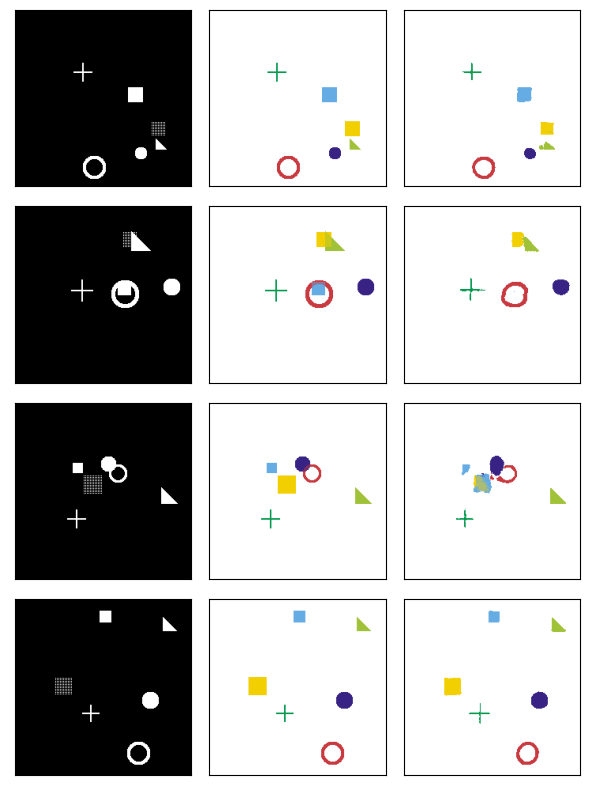

In [30]:
model.eval()   

inputs, labels = next(iter(val_dataloder))
inputs = inputs.to(device)[:4]
labels = labels.to(device)[:4]

pred = model(inputs)

pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()

input_images_rgb = [inverse_transforms(x).permute(1, 2, 0) for x in inputs.cpu()]

target_masks_rgb = [utils.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [utils.masks_to_colorimg(x) for x in pred]

utils.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

## `Как использовать предобученную сеть из torch.hub`

In [31]:
?torch.hub.load

Загрузим сеть [**deeplabv3+**](https://arxiv.org/pdf/1802.02611v3.pdf):

In [32]:
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights

In [33]:
model = torch.hub.load(
    'pytorch/vision:v0.10.0', 'deeplabv3_resnet50', 
    weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to C:\Users\nahod/.cache\torch\hub\v0.10.0.zip
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to C:\Users\nahod/.cache\torch\hub\checkpoints\deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

In [34]:
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/deeplab1.png", "deeplab1.png")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [35]:
from PIL import Image
from torchvision import transforms

# откроем картинку из интернета
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) 

model.to(device)
model.eval()
with torch.no_grad():
    input_batch = input_batch.to(device)
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)
output_predictions

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')

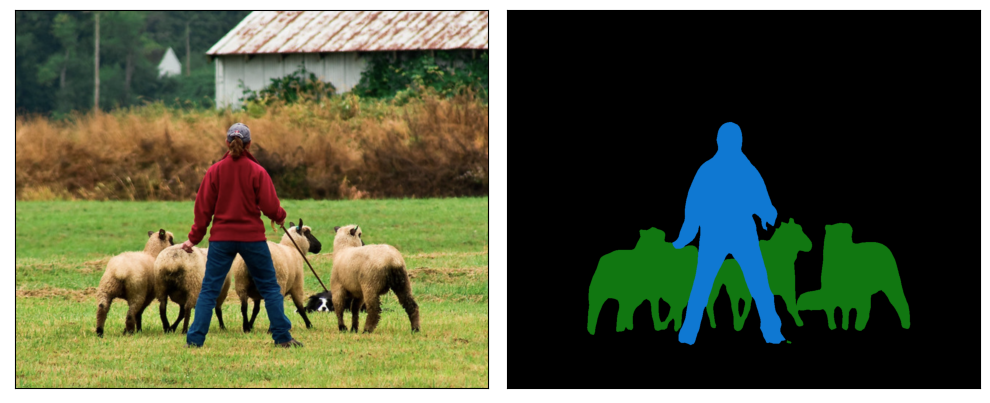

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# create a color pallette, selecting a color for each class
palette = np.array([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = np.arange(21)[:, None]* palette
colors = (colors % 255).astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
image_mask = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
image_mask.putpalette(colors)

for ax, image in zip(axes.reshape(-1), [input_image, image_mask]):
    ax.imshow(image)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()